# Module 1 Project

Please fill out:
* Student name: Jennifer Wadkins
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:



Questions I have:
    * Do I need to justify not using provided data, or can I just go straight for my own?
    * Am I allowed to make some assumptions/framing for the case study, ex. set in a pre-covid world?

## Project Overview

## Other preparation work

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions

## Importing our modules

We will be using the following libraries in this project:

pandas, numpy, matplotlib, json, re

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json
import re
%matplotlib inline

## Project Steps

    1) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    2) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    3) EDA on data sets including visualizations

## Notebook Functions

In [2]:
def string_cleanup(text):
    '''takes in an object, converts to string, and removes all non-word characters'''
    text = str(text)
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    return result

In [3]:
# function to convert a list in string format into a true list
def convert_to_list(string):
    '''Takes a string that looks like a list but is actually a string. Turns it into an actual list.'''
    try:
        li = string.lstrip('[')
        li = li.rstrip(']')
        li = li.replace(" ", '')
        li = list(li.split(","))
        li = [int(x) for x in li]
        return li
    except:
        return None

In [4]:
# write a function to convert the cost/gross object entries into proper numbers that we can use in calculation
def convert_numbers(x):
    '''Takes in a string formatted number that starts with $ and may include commas, and returns that 
    number as a whole integer that can be used in calculations'''
    x = x[1:]
    x = x.replace(',', '')
    x = int(x)
    return x

# Project Step 1 - Data Aquisition and Cleaning

Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.

## Source 1 - The Movie Database

First we will look at our provided data set from TMDB and see how they need cleaning. When performing cleaning analysis on ALL datasets in this project, we initially want to know things like:

    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

### Exploring the Data - original TMDB file

In [5]:
# importing the movie database movies data set from file
tmdb = pd.read_csv('zippedData/tmdb.movies.csv')

In [6]:
# taking a look at what we've imported
tmdb.head(10)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
5,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
7,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340
8,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057
9,9,"[16, 28, 35, 10751, 878]",38055,en,Megamind,22.855,2010-11-04,Megamind,6.8,3635


In [7]:
# what is the shape of our data?
tmdb.shape
# this dataset has 26,517 movie entries. At first glance we are very excited about all of this data!

(26517, 10)

In [8]:
# do we have any missing/null values?
tmdb.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't placeholders


Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [9]:
tmdb.describe()
# One thing we can see in this dataset is that there are a LOT of movies with 5 or fewer votes. A full 50% of the dataset
# has 5 or fewer votes. The difference between or 75th percentile and the max goes from 28 to 22,000 votes!!

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [10]:
tmdb['vote_count'].value_counts()
# There are 6541 entries in this dataset with only 1 votex

1       6541
2       3044
3       1757
4       1347
5        969
        ... 
2328       1
6538       1
489        1
2600       1
2049       1
Name: vote_count, Length: 1693, dtype: int64

In [11]:
tmdb.sort_values('popularity')
# while sorting on popularity, I also notice for the first time that a lot of the genre_ids on this low popularity list are absent


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
13258,13258,[99],403294,en,9/11: Simulations,0.600,2014-07-04,9/11: Simulations,10.0,1
11010,11010,[],203325,en,Slaves Body,0.600,2013-06-25,Slaves Body,0.5,1
11011,11011,[99],186242,en,Re-Emerging: The Jews of Nigeria,0.600,2013-05-17,Re-Emerging: The Jews of Nigeria,0.5,2
11012,11012,[99],116868,en,Occupation: Fighter,0.600,2013-08-02,Occupation: Fighter,0.5,2
11013,11013,[99],85337,en,Wonders Are Many: The Making of Doctor Atomic,0.600,2013-08-07,Wonders Are Many: The Making of Doctor Atomic,0.5,2
...,...,...,...,...,...,...,...,...,...,...
5179,5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673
11020,11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392
23812,23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048
11019,11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081


In [12]:
tmdb[(tmdb['vote_count'] > 30)].count()
# we only have 6347 entries in this dataset with more than 30 user votes. I question the quality of this dataset.
# Overall, this might just not be great data, and since we have access to a TMDB API, we will pull better data
# ourselves

Unnamed: 0           6347
genre_ids            6347
id                   6347
original_language    6347
original_title       6347
popularity           6347
release_date         6347
title                6347
vote_average         6347
vote_count           6347
dtype: int64

### Pulling Data from TMDB via API

Instead of using the provided data set from TMDB, we're going to pull the specific movie data that we want to use from TMDB using an API key. 

We're accessing the API documentation for TMDB at https://developers.themoviedb.org/3/getting-started/introduction, after registering for an API key.

We can see some interesting options with the TMDB API that want to add to our data including:
    * Movie genre list to match up with the genre-ids (under Genres)
    * More up-to-date dataset in general, retrieved with some predetermined data refinement critera 
    * A list of the IMDB movie ids, which will be incredibly helpful for us to join this TMDB info with our IMDB info later in the notebook (under Movies -> Get External IDs)
    


### Movie Genres Matchup

TMDB allows for browser-based API calls, which works well for small simple calls. We used their browser system for this simple call to get the movie genre names to match the TMDB movie genre IDs. We copied the text results into our source code editor Notepad++, and saved as a JSON

We used https://developers.themoviedb.org/3/genres/get-movie-list to get a JSON dictionary of movie genres.

In [13]:
# We saved the resulting web-based text return as a JSON using our source code editor, and now we load it
f = open('api_data/tmdb_movie_genres.json')
data = json.load(f)
data

{'genres': [{'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 16, 'name': 'Animation'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 80, 'name': 'Crime'},
  {'id': 99, 'name': 'Documentary'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14, 'name': 'Fantasy'},
  {'id': 36, 'name': 'History'},
  {'id': 27, 'name': 'Horror'},
  {'id': 10402, 'name': 'Music'},
  {'id': 9648, 'name': 'Mystery'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 10770, 'name': 'TV Movie'},
  {'id': 53, 'name': 'Thriller'},
  {'id': 10752, 'name': 'War'},
  {'id': 37, 'name': 'Western'}]}

In [14]:
# converting our nested dictionary into a mapping dictionary

genres = data['genres']

tmdb_genres = {}

for x in range(len(genres)):
    tmdb_genres[(genres[x]['id'])] = genres[x]['name']

tmdb_genres

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

### Discover Data Set

The big workhorse API for TMDB is in "Discover" located at https://developers.themoviedb.org/3/discover/movie-discover

In this section we can get back a data set that can, in some ways, be pre-cleaned. So we are going to determine how we plan to refine/clean our data set right now, and then figure out ways that we can pull data from TMDB that already fits the parameters we want.

Here are the data cleanup steps we are planning for our data set, some of which can be achieved while we grab the data:

    * Drop entries with fewer than 30 votes. Our client is looking for a blockbuster, not a bespoke production.
    * Drop entries with no genre specified. We'll want to use the genre to make recommendations.
    * Drop entries with 1.0 or less popularity, for the same reasons as votes
    * Drop movies older than 2000. We want a relatively current dataset in order to make proper recommendations.
    
The Discover API lets us pass the following useful parameters to fulfill some of our data refinement goals:
    * primary_release_date.gte lets us include movies that have a primary release date greater or equal than the specified value
    * primary_release_date.lte lets us pass a primary release date lesser than or equal than the specified value. This will keep our scope in 2019 or older for purposes of our case study. We're looking at movie production in a pre-covid world.
    * vote_count.gte lets us filter for movies with a vote count greater than or equal to the specified value
    * with_original_language lets us pull english language films. Our client will be making films in english

This will take care of a few of the things we wanted to clean up in our dataset.
 
We're getting this and other API data in a separate notebook, because we don't want to make these API calls every time we run this notebook! We've pulled the data via the notebook called "tmdb_api_calls" and saved it as a JSON file, and will now import our JSON file here for further processing.

#### !!!!! STOP !!!!! Go to the notebook at tmdb_api_calls.ipynb and run the first section titled "Discover Data Set" now.

Alternatively, load in the provided csv below where we have already done this task.

In [15]:
# opening up our Discover dataset

f = open('api_data/tmdb_movies.json', encoding='utf-8')
discover = json.load(f)

type(discover) # we've loaded our Discover dataset and it's a dictionary

dict

In [16]:
discover.keys() # checking the keys
# we ran our function to paginate in the API and as a result, our keys are each of the 500 calls we made to the api. We'll
# need to go a level lower to hit our data.

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [17]:
# what does the first level of our dictionary look like?
discover['1']
# This is page 1 of the results

discover['1']['results']
# these are the entries on page 1. Our plan now is to write a loop to iterate through the pages, and concatenate the 
# results onto our dataframe tmdb_discover

[{'popularity': 520.621,
  'vote_count': 12639,
  'video': False,
  'poster_path': '/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg',
  'id': 354912,
  'adult': False,
  'backdrop_path': '/askg3SMvhqEl4OL52YuvdtY40Yb.jpg',
  'original_language': 'en',
  'original_title': 'Coco',
  'genre_ids': [16, 10751, 35, 12, 14, 10402],
  'title': 'Coco',
  'vote_average': 8.2,
  'overview': "Despite his family’s baffling generations-old ban on music, Miguel dreams of becoming an accomplished musician like his idol, Ernesto de la Cruz. Desperate to prove his talent, Miguel finds himself in the stunning and colorful Land of the Dead following a mysterious chain of events. Along the way, he meets charming trickster Hector, and together, they set off on an extraordinary journey to unlock the real story behind Miguel's family history.",
  'release_date': '2017-10-27'},
 {'popularity': 330.357,
  'vote_count': 15378,
  'video': False,
  'poster_path': '/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg',
  'id': 475557,
  'adult': Fal

In [18]:
tmdb_discover = pd.DataFrame() #start by making an empty dataframe to hold our results

# loop through each page of our response JSON, make it into a dataframe, and concatenate onto our big dataframe
for x in discover:
    df = pd.DataFrame.from_dict(discover[x]['results'])
    tmdb_discover = pd.concat([tmdb_discover, df])

tmdb_discover #finished dataframe

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,520.621,12639,False,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,354912,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,en,Coco,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,Despite his family’s baffling generations-old ...,2017-10-27
1,330.357,15378,False,/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg,475557,False,/n6bUvigpRFqSwmPp1m2YADdbRBc.jpg,en,Joker,"[80, 53, 18]",Joker,8.2,"During the 1980s, a failed stand-up comedian i...",2019-10-02
2,288.149,5133,False,/zfE0R94v1E8cuKAerbskfD3VfUt.jpg,474350,False,/8moTOzunF7p40oR5XhlDvJckOSW.jpg,en,It Chapter Two,"[27, 14]",It Chapter Two,6.9,27 years after overcoming the malevolent super...,2019-09-04
3,257.243,6344,False,/qXsndsv3WOoxszmdlvTWeY688eK.jpg,330457,False,/xJWPZIYOEFIjZpBL7SVBGnzRYXp.jpg,en,Frozen II,"[16, 10751, 12, 35, 14]",Frozen II,7.3,"Elsa, Anna, Kristoff and Olaf head far into th...",2019-11-20
4,216.184,4925,False,/jyw8VKYEiM1UDzPB7NsisUgBeJ8.jpg,512200,False,/zTxHf9iIOCqRbxvl8W5QYKrsMLq.jpg,en,Jumanji: The Next Level,"[12, 35, 14]",Jumanji: The Next Level,7.0,As the gang return to Jumanji to rescue one of...,2019-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,4.837,61,False,/aDEsuy1CsQrK2EZLeBRcD9IKIxZ.jpg,16048,False,None,en,All About Anna,"[35, 18, 10749]",All About Anna,3.2,"Anna is a young costume designer, focused on h...",2005-11-24
16,4.836,67,False,/2YyasmVeayH4DH0BfaeYsT06D6k.jpg,24959,False,None,en,Program,"[16, 878]",Program,6.9,Cis and Duo discuss leaving the real world whi...,2003-02-07
17,4.830,72,False,/kXBvc3wkK33ibj9HK7pF9X0Uiwe.jpg,127144,False,/emsrOarrzzjrPIJPpp53jzxqk3w.jpg,en,Don't Hug Me I'm Scared,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,A disturbing puppet short exploring the concep...,2011-07-25
18,4.830,40,False,/tLwDdvsgQecx6SopQM9XEp8J1fY.jpg,41488,False,/af1veNOoA5Mkxxh3EEOGoKdcWwF.jpg,en,The Statement,"[18, 53]",The Statement,5.7,"The film is set in France in the 1990s, the Fr...",2003-12-12


By pre-filtering for year 2000 or later, 31+ votes, and english language films, we hit the 10,000 results limit with the TMDB API. However we can see that the default sort on this data set is via popularity, so we will conclude that we have gotten the 10,000 most popular movies since 2000, and be happy with the quality of this data.

We are definitely going to use this data instead of the provided TMDB dataset, which had around 6,000 results after removing <30 votes, but had not yet been filtered for after year 2000 OR english language. 

We are NOT using the provided TMDB dataset from earlier in the notebook. We've found that we have higher quality data via our API pull, and will be using our tmdb_discover dataset and discarding our tmdb dataset.

### Exploring the Data - Part 2

In [19]:
tmdb_discover.shape
# we have 10,000 entries

(10000, 14)

In [20]:
tmdb_discover.dtypes
# we'll take a look at fixing the release_date format and converting that to a proper datetime. Everything else looks correct.

popularity           float64
vote_count             int64
video                   bool
poster_path           object
id                     int64
adult                   bool
backdrop_path         object
original_language     object
original_title        object
genre_ids             object
title                 object
vote_average         float64
overview              object
release_date          object
dtype: object

In [21]:
tmdb_discover.describe()
# we can see that we have meaningful data with a reasonable vote_count per entry and high popularity

,popularity,vote_count,id,vote_average
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,16.046719,877.56510,182247.233400,6.119470
std,16.794699,2058.38094,181421.224833,0.943012
min,4.821000,31.00000,12.000000,1.500000
25%,8.810000,60.00000,17027.750000,5.500000
50%,11.624500,155.00000,91040.000000,6.200000
75%,16.853500,653.00000,339445.750000,6.800000
max,520.621000,27507.00000,704264.000000,9.000000


In [22]:
tmdb_discover[(tmdb_discover['genre_ids'] == '[]')].count()
# All of our entries have genre ids, so nothing we need to drop.

popularity           0
vote_count           0
video                0
poster_path          0
id                   0
adult                0
backdrop_path        0
original_language    0
original_title       0
genre_ids            0
title                0
vote_average         0
overview             0
release_date         0
dtype: int64

In [23]:
tmdb_discover.isnull().sum()
# we have no null or missing values in our dataset in the columns we need to use

popularity             0
vote_count             0
video                  0
poster_path           13
id                     0
adult                  0
backdrop_path        989
original_language      0
original_title         0
genre_ids              0
title                  0
vote_average           0
overview               0
release_date           0
dtype: int64

### Data Cleanup

What do we actually need to use from this data set?

We'll be using this data set as the basis for all further connections in this project, as the TMDB API allowed us to gather both the most up-to-date information as well as provides us with important details such as a specific release date and genres.

We're going to do the following work on this dataset to clean it up:
    
    a) change our release date to standard format
    b) Drop unneeded columns
        * video - we know all of these values are false, as it was part of our API parameters
        * poster_path - provides a path to an image for the movie, which we don't need
        * adult - we know all of these values are false, as it was part of our API parameters
        * backdrop_path - another set of images, which we don't need
        * original_titles - if the movie is in a foreign language, the original title is here, we only need the english titles
        * overview - summary description of the movie, which we cannot use in visualization
        * original_language - we're only using english language movies, so this is a redundant field


In [24]:
tmdb_discover.columns
# show column names so I can see what to drop in the next line of code

Index(['popularity', 'vote_count', 'video', 'poster_path', 'id', 'adult',
       'backdrop_path', 'original_language', 'original_title', 'genre_ids',
       'title', 'vote_average', 'overview', 'release_date'],
      dtype='object')

In [25]:
# cleaning up this dataset

#drop columns by name
tmdb_discover.drop(columns=['video', 'poster_path', 'adult', 'backdrop_path', 'original_title', 'overview', 'original_language'], inplace=True)

In [26]:
# using pandas built-in datetime converter to change our release date column to standard format
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [27]:
tmdb_discover.dtypes

popularity             float64
vote_count               int64
id                       int64
genre_ids               object
title                   object
vote_average           float64
release_date    datetime64[ns]
dtype: object

In [28]:
tmdb_discover # confirming that we have cleaned up our data and have only the information we need to use

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
0,520.621,12639,354912,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
1,330.357,15378,475557,"[80, 53, 18]",Joker,8.2,2019-10-02
2,288.149,5133,474350,"[27, 14]",It Chapter Two,6.9,2019-09-04
3,257.243,6344,330457,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
4,216.184,4925,512200,"[12, 35, 14]",Jumanji: The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...,...
15,4.837,61,16048,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
16,4.836,67,24959,"[16, 878]",Program,6.9,2003-02-07
17,4.830,72,127144,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,2011-07-25
18,4.830,40,41488,"[18, 53]",The Statement,5.7,2003-12-12


We need this data set in order to make our API calls for the IMDB ID matchup, so we're going to export it to a csv that we can then import into our API production file.

In [29]:
# Exporting our csv so that we can make our API calls to match up IMDB ID
#tmdb_discover.to_csv('api_data/tmdb_discover.csv', index=False)

### IMDB ID Matchup

Our next goal is to match up IMDB movie ids for each of the movie ids in our data set. TMDB has an API to do exactly this - submit the TMDB id, and get an IMDB id in return. Each TMDB movie id is a parameter that must be passed to an individual API call, so we won't be using the web interface for this action.

We move to the tmdb_api_calls notebook to do this process.

We've exported our Discover Data Set up above and will process it in our API notebook, and will then re-import it here with our TMDB ids replaced with IMDB ids!

#### !!! STOP !!! Go to the API notebook tmdb_api_calls.ipynb and run the second section titled "IMDB ID Matchup" now.
Alternatively, load in the provided csv where we have already done this task.

In [30]:
tmdb_discover = pd.read_csv('api_data/tmdb_discover_converted.csv')

tmdb_discover.sort_values('id')
# we now have our original tmdb_discover dataset converted to IMDB ids instead of TMDB ids.
# We'll be able to cross reference this set later on with IMDB datasets.

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
5292,11.247,920,tt0035423,"[35, 14, 10749]",Kate & Leopold,6.2,2001-12-25
7578,8.725,106,tt0069049,"[35, 18]",The Other Side of the Wind,6.8,2018-11-02
5740,10.757,93,tt0118589,"[18, 10749]",Glitter,4.4,2001-09-21
8438,7.791,36,tt0118926,"[80, 18, 10749, 53]",The Dancer Upstairs,6.6,2002-09-20
7842,8.418,48,tt0119004,[18],Don's Plum,5.7,2001-02-10
...,...,...,...,...,...,...,...
122,74.998,35,tt9896916,"[12, 16]",The Pilgrim's Progress,7.6,2019-04-18
717,33.075,400,NaN,"[28, 35]",Once Upon a Deadpool,6.9,2018-12-11
4532,12.272,141,NaN,"[28, 16, 14, 878]",Hulk vs. Thor,6.6,2009-01-27
5226,11.321,147,NaN,"[16, 28, 878, 12, 14]",Hulk vs. Wolverine,6.9,2009-01-27


In [31]:
# We didn't find four IMDB IDs
tmdb_discover['id'].notna().sum()

9996

In [32]:
# We didn't find four IMDB IDs, so we will drop them
tmdb_discover.dropna(subset=['id'], inplace=True)

In [33]:
# We hope to use the titles to match up to some other data later 
# so we use the string cleanup function to remove special characters from the titles

tmdb_discover['title'] = tmdb_discover['title'].map(lambda x: string_cleanup(x))

In [34]:
#Now that we have replaced our TMDB id with IMDB id, we'll set the IMDB id as our index
tmdb_discover.set_index('id', inplace=True)

In [35]:
# check our data types
tmdb_discover.dtypes

popularity      float64
vote_count        int64
genre_ids        object
title            object
vote_average    float64
release_date     object
dtype: object

In [36]:
# looks like the datetime type does not persist across exports and imports.
# We'll use the pandas built-in datetime converter to change our release date column to standard format (again)
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [37]:
# Converting our genre_ids (which LOOK like lists) into actual lists of integers
tmdb_discover['genres'] = tmdb_discover['genre_ids'].map(lambda x: convert_to_list(x))

In [38]:
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres
id,,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27,"[16, 10751, 35, 12, 14, 10402]"
tt7286456,330.357,15378,"[80, 53, 18]",Joker,8.2,2019-10-02,"[80, 53, 18]"
tt7349950,288.149,5133,"[27, 14]",It Chapter Two,6.9,2019-09-04,"[27, 14]"
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20,"[16, 10751, 12, 35, 14]"
tt7975244,216.184,4925,"[12, 35, 14]",Jumanji The Next Level,7.0,2019-12-04,"[12, 35, 14]"
...,...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",All About Anna,3.2,2005-11-24,"[35, 18, 10749]"
tt0366178,4.836,67,"[16, 878]",Program,6.9,2003-02-07,"[16, 878]"
tt2501618,4.830,72,"[27, 14, 16]",Dont Hug Me Im Scared,7.5,2011-07-25,"[27, 14, 16]"


### Export Web Scraper File

We now will export our completed tmdb_discover file in order to use it to scrape Box Office Mojo.

In [39]:
#exporting the dataframe to a csv to use with our web scraper
#tmdb_discover.to_csv('api_data/tmdb_imdb_ids.csv')

## Source 2 - Box Office Mojo

Box Office Mojo is part of IMDB pro and does not offer a personal-use API. We started with our movie data of 10,000 entries from TMDB and used another TMDB API to obtain all of the IMDB IDs for those 10,000 movies. Now, we will use our web scraper in our notebook bom_scraper to use the IMDB ID at Box Office Mojo and IMDB to find MPAA rating, studio, domestic gross, foreign gross and budget information for each movie, if available

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

### Exploring the Data

In [40]:
#Box Office Mojo movie grosses and IMDB MPAA ratings
bom = pd.read_csv('api_data/tmdb_bom_scraped.csv')

In [41]:
bom

,id,studio,rating,budget,dom_gross,world_gross
0,tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08
1,tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09
2,tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08
3,tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09
4,tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08
...,...,...,...,...,...,...
9991,tt0349080,NaN,0,NaN,NaN,NaN
9992,tt0366178,NaN,0,NaN,NaN,NaN
9993,tt2501618,NaN,0,NaN,NaN,NaN
9994,tt0340376,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06


In [42]:
# what is the shape of our data?
bom.shape
# this dataset has 3251 movie entries

(9996, 6)

In [43]:
# what kind of data is stored?
bom.dtypes
# Most of this data is stored correctly. We'll be mapping our ratings to numbers, but we do expect to see objects right now

id              object
studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
dtype: object

In [44]:
# do we have any missing/null values?
bom.isnull().sum()
# This dataset is not missing any IMDB IDs. We to have some missing data in other categories

id                0
studio         4498
rating            0
budget         7545
dom_gross      4703
world_gross    3267
dtype: int64

### Data Cleanup

We performed some of our data cleanup during our web scrape, but we'll be doing these additional tasks:

    * Map our MPAA rating to a number so we can use this categorical data
    * Set our IMDB ID as the index so we can join on this field later

In [45]:
#We're mapping our MPAA Rating to a number in a new column

ratings_map = {'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4, 'NC-17': 5, 'NR': 6, '0': 0}

bom['mpaa_rating'] = bom['rating'].map(ratings_map)

In [46]:
# no missing ratings

bom['mpaa_rating'].isnull().sum()

0

In [47]:
# set IMDB id as the index

bom.set_index('id', inplace=True)

In [48]:
# Our mpaa_rating is an integer field, as desired

bom.dtypes

studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
mpaa_rating      int64
dtype: object

In [49]:
bom

,studio,rating,budget,dom_gross,world_gross,mpaa_rating
id,,,,,,
tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2
tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4
tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4
tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2
tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3
...,...,...,...,...,...,...
tt0349080,NaN,0,NaN,NaN,NaN,0
tt0366178,NaN,0,NaN,NaN,NaN,0
tt2501618,NaN,0,NaN,NaN,NaN,0


## Source 3 - IMDB
   
While we do our exploration and cleanup analysis on each of these IMDB data sets, we'll explore how they will interact with each other when we merge them. We'll determine what needs to be cleaned before vs after merging the datasets.

### IMDB1 - User user_ratings per movie ID

In [50]:
# import imdb user user_ratings per movie
imdb1 = pd.read_csv('zippedData/title.ratings.csv')

#### Exploring the Data

In [51]:
# taking a look at what we've imported
imdb1
# this dataset is using the movie id and showing the average user_rating, and the number of votes
# this dataset has 73,856 movie entries

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [52]:
# what kind of data is stored?
imdb1.dtypes
# The data in this set appears to be stored in the proper formats

tconst            object
averagerating    float64
numvotes           int64
dtype: object

In [53]:
# do we have any missing/null values?
imdb1.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't categorical placeholders, and we will look into that further

tconst           0
averagerating    0
numvotes         0
dtype: int64

In [54]:
round(imdb1.describe(), 2)

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


#### Data Cleanup

In [55]:
#We make the unique IMDB ID "tconst" into our index. We'll be joining on this id for many of our data sets.
imdb1.set_index('tconst', inplace=True)

In [56]:
imdb1

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


### IMDB2 - Cast and crew per movie ID

In [57]:
# import imdb primary cast and crew per movie
imdb2 = pd.read_csv('zippedData/title.principals.csv')

#### Exploring the Data

In [58]:
# taking a look at what we've imported
imdb2
# this dataset is using the movie id and showing the principal cast and crew for each movie, by the cast/crew id
# this dataset has 1,028,186 cast and crew entries

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [59]:
# do we have any missing/null values?
imdb2.isnull().sum()
# This dataset has large numbers of missing values. We will inspect the data itself to determine if this is important.

tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64

In [60]:
temp = imdb2.loc[(imdb2['job'].notnull())]
temp
# job seems very closely related to category. Only 177k (out of over 1mil) entries have this category filled
# and it's largely a duplicate or reword of category. We will drop this column.

,tconst,ordering,nconst,category,job,characters
2,tt0111414,3,nm3739909,producer,producer,NaN
9,tt0323808,6,nm0811056,producer,producer,NaN
10,tt0323808,7,nm0914939,producer,producer,NaN
19,tt0417610,6,nm0083201,writer,story,NaN
20,tt0417610,7,nm0147416,producer,producer,NaN
...,...,...,...,...,...,...
1028140,tt9670894,9,nm10480024,writer,dialogue,NaN
1028148,tt9672244,7,nm3279394,writer,poem,NaN
1028172,tt9681728,6,nm7442758,producer,producer,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [61]:
# What is the characters category for?
temp = imdb2.loc[(imdb2['characters'].notnull())]
temp
# it seems unimportant to know what character the actors and actresses play. We can't really use that information.
# we will drop this column

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,NaN,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,NaN,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,NaN,"[""Lady Delia Morrison""]"
...,...,...,...,...,...,...
1028170,tt9681728,4,nm10436662,actor,NaN,"[""Alexey""]"
1028174,tt9681728,8,nm10436663,actor,NaN,"[""Makar Petrovich""]"
1028175,tt9681728,9,nm10397910,actor,NaN,"[""Corpsman""]"
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"


After studying this dataset, we see that the movie id (tconst) is not unique. Because of this, we will not turn the tconst value into the index in this data set.

#### Data Cleanup

We will remove three unnecessary columns that are not needed for making recommendations.

In [62]:
# After inspecting the data, we can see that the "job" column is generally an extension of the "category" column 
# We will drop this column.
imdb2.drop(columns=['job'], inplace=True)

# We can also see that the "ordering" column is just for sorting the different jobs for each movie id
# We will drop this column.
imdb2.drop(columns=['ordering'], inplace=True)

# lastly, we want all of our data to contribute to a recommendation, and while the actors themselves may be important,
# the characters they play do not seem particularly important. We will drop this column.
imdb2.drop(columns=['characters'], inplace=True)

In [63]:
imdb2

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress
...,...,...,...
1028181,tt9692684,nm0186469,actor
1028182,tt9692684,nm4929530,self
1028183,tt9692684,nm10441594,director
1028184,tt9692684,nm6009913,writer


### IMDB3 - Director and writer assignments per movie id

In [64]:
#IMDB directors and writers per movie
imdb3 = pd.read_csv('zippedData/title.crew.csv')

#### Exploring the Data

This appears to give the same information as the previous data set, but in a different format. Let's do a few comparisons and see if that is the case.

In [65]:
imdb3.head(10)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
5,tt0879859,nm2416460,NaN
6,tt0996958,nm2286991,"nm2286991,nm2651190"
7,tt0999913,nm0527109,"nm0527109,nm0329051,nm0001603,nm0930684"
8,tt10003792,nm10539228,nm10539228
9,tt10005130,nm10540239,"nm5482263,nm10540239"


In [66]:
temp = imdb2.loc[imdb2['tconst'] == 'tt0835418']
temp
# for our entry tt0835418, imdb3 shows our director is nm0151540 and our writers are nm0310087, nm0841532
# let's check if it's the same in our imdb2 set

,tconst,nconst,category
144119,tt0835418,nm0790481,composer
144120,tt0835418,nm0773973,actor
144121,tt0835418,nm1601397,actress
144122,tt0835418,nm0373571,actor
144123,tt0835418,nm0365445,actor
144124,tt0835418,nm0151540,director
144125,tt0835418,nm0310087,writer
144126,tt0835418,nm0841532,writer
144127,tt0835418,nm0089658,producer
144128,tt0835418,nm2271939,producer


In [67]:
# let's check one more multi-role
temp = imdb2.loc[imdb2['tconst'] == 'tt0999913']
temp
# we have 1 director and 3 writers listed in our imdb2

,tconst,nconst,category
144169,tt0999913,nm0343935,composer
144170,tt0999913,nm0005188,actor
144171,tt0999913,nm0098378,actress
144172,tt0999913,nm0002907,actor
144173,tt0999913,nm0000249,actor
144174,tt0999913,nm0527109,director
144175,tt0999913,nm0329051,writer
144176,tt0999913,nm0001603,writer
144177,tt0999913,nm0930684,writer
144178,tt0999913,nm0296827,producer


In [68]:
# compare with our imdb3:
temp = imdb3.loc[imdb3['tconst'] == 'tt0999913']
temp
# 1 director and 4 writers, where one of the writers is the director.

,tconst,directors,writers
7,tt0999913,nm0527109,"nm0527109,nm0329051,nm0001603,nm0930684"


In [69]:
# Let's take a look at a listing from this dataset with no writer attached in our imdb3
temp = imdb2.loc[imdb2['tconst'] == 'tt0879859']
temp
# there is indeed no writer attached to this movie according to imdb2

,tconst,nconst,category
144129,tt0879859,nm1269186,editor
144130,tt0879859,nm0028844,actor
144131,tt0879859,nm2421419,actress
144132,tt0879859,nm0090301,actress
144133,tt0879859,nm3127072,actress
144134,tt0879859,nm2416460,director
144135,tt0879859,nm0505953,producer
144136,tt0879859,nm0614195,producer
144137,tt0879859,nm1244349,composer
144138,tt0879859,nm0806706,cinematographer


#### Data Cleanup

Based on what we are seeing here, we are NOT going to use this dataset. We'll use the other cast and crew dataset to get this same information already broken apart, rather than having to break apart this dataset.

### IMDB4 - Movie stats per movie ID

In [70]:
# import imdb stats per movie
imdb4 = pd.read_csv('zippedData/title.basics.csv')

#### Exploring the Data

In [71]:
# taking a look at what we've imported
imdb4
# this dataset is using the movie id and finally we have the title of the movie, as well as the year, the runtime, and the genres
# this dataset has 146,144 movie entries

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [72]:
# what kind of data is stored?
imdb4.dtypes
# The data in this set appears to be stored in the proper formats

tconst              object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

In [73]:
# what are our columns?
imdb4.columns
# The 'tconst' is found throughout our IMDB datasets and is the IMDB ID
# we may want to understand the distinction between primary_title and original_title

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [74]:
# do we have any missing/null values?
imdb4.isnull().sum()
# This dataset has some missing values. We will inspect the data itself to determine if this is important.
# there are no primary titles or years missing, which seems like the most important data to have

tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [75]:
imdb4.describe()
# the IMDB dataset starts at 2010, and includes unreleased future movies.
# That's unhelpful, but we plan to use tmdb_discover as our base set to left join to, so it doesn't really matter.

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


We don't really have much use for this data, because we've directly pulled all of this data plus more into the tmdb_discover data set. 

Why are there so many more entries in this dataset than the tmdb dataset which is from 2000 onward?

Our first hint is the number of obvious foreign language films in the dataset preview above. Our tmdb API pull focused only on movies in english. This list also is not filtered on reviews in order to reduce the number of small-scale entries. This list also includes movies with release dates in the future.

We have no real need to filter these things at this time. The unneeded movies entires will be dropped when we join to tmdb_discover on a left join.

#### Data Cleanup

We'll later be merging this dataframe into our more robust tmdb_discover data set, so we don't need all of the information in this data set. In fact, we might not need ANY of this information, except maybe runtime. All of the other information is better represented in our tmdb_discover dataset. For now, we won't be cleaning this data much further, as this set seems to be a less-specific set with redundant information.

We DO want any user user_ratings available from IMDB, to merge with the user user_ratings from tmdb_discover. So we'll do a few things on this dataset before joining with imdb1:

    1) set our IMDB id as our index
    2) Dropping redundant columns "original_title", 'primary_title', 'start_year', 'genres'
    

In [76]:
# Set tconst movie id as index
imdb4.set_index('tconst', inplace=True)

# Drop original_title column
imdb4.drop(columns=["original_title", 'primary_title', 'start_year', 'genres'], inplace=True)

#### Data Combining IMDB1 and IMDB4

We want the average user_rating and number of votes to be attached to our imdb4 database, from our imdb1 database.

In [77]:
imdb4 = imdb4.join(imdb1, how="left")
imdb4

,runtime_minutes,averagerating,numvotes
tconst,,,
tt0063540,175.0,7.0,77.0
tt0066787,114.0,7.2,43.0
tt0069049,122.0,6.9,4517.0
tt0069204,NaN,6.1,13.0
tt0100275,80.0,6.5,119.0
...,...,...,...
tt9916538,123.0,NaN,NaN
tt9916622,NaN,NaN,NaN
tt9916706,NaN,NaN,NaN


The user_ratings are now in with the movie entries, and we're ready to attach this data to our tmdb_discover dataset, which will drop a lot of unnecessary entries without us having to filter them manually.

### IMDB5 - Alternate titles per movie ID

In [78]:
# import imdb alternate titles
imdb5 = pd.read_csv('zippedData/title.akas.csv')

#### Exploring the Data

In [79]:
# taking a look at what we've imported
imdb5

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0


#### Data Cleanup

It is immediately apparent that this dataset lists all of the alternate titles for each movie id.

We won't be using this dataset.

### IMDB6 - Detailed crew info per person ID

In [80]:
# import imdb detailed crew information
imdb6 = pd.read_csv('zippedData/name.basics.csv')

#### Exploring the Data

In [81]:
# taking a look at what we've imported
imdb6
# this dataset has the information about the cast and crew ids that we saw earlier in imdb2 and imdb3
# this dataset has 606,648 people entries

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


In [82]:
# what kind of data is stored?
imdb6.dtypes
# The data in this set appears to be stored in the proper formats

nconst                 object
primary_name           object
birth_year            float64
death_year            float64
primary_profession     object
known_for_titles       object
dtype: object

In [83]:
# what are our columns?
imdb6.columns

Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object')

In [84]:
# do we have any missing/null values?
imdb6.isnull().sum()
# This dataset has a lot of missing values for birth year, death year, profession, and known for.
# We don't need some of this information, including birth year, profession and known for
# We will keep death year to make sure we don't make any recommendations for cast/crew that is deceased

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64

#### Data Cleanup

In [85]:
# the only info we need on people is if they are alive, so we will drop their year of birth
imdb6.drop(columns=['birth_year'], inplace=True)

# We don't need the specific professions of our players. We can see their role from dataset 5
imdb6.drop(columns=['primary_profession'], inplace=True)

# We're going to use other, more quantifiable metrics of popularity than the known for information
imdb6.drop(columns=['known_for_titles'], inplace=True)

# we will make the unique nconst the index
imdb6.set_index('nconst', inplace=True)

In [86]:
imdb6.head()
imdb6.sort_values('death_year').head()
# now we realize that we can have writers and composers that are long deceased.

,primary_name,death_year
nconst,,
nm0653992,Ovid,17.0
nm0613556,Shikibu Murasaki,1031.0
nm0019604,Dante Alighieri,1321.0
nm0090504,Giovanni Boccaccio,1375.0
nm1063158,Cheng'en Wu,1581.0


In [87]:
# We can't recommend someone who is dead. Some of these people died long ago, indicating they are the writers of 
# an adapted work, so there is probably another writer on the project. Either way we don't need any of the dead people.

imdb6.drop(imdb6[imdb6['death_year'].notnull()].index, inplace=True)

In [88]:
# now that we've sorted out the dead, we can drop this column
imdb6.drop(columns='death_year', inplace=True)

In [89]:
imdb6

,primary_name
nconst,
nm0061671,Mary Ellen Bauder
nm0061865,Joseph Bauer
nm0062070,Bruce Baum
nm0062195,Axel Baumann
nm0062798,Pete Baxter
...,...
nm9990381,Susan Grobes
nm9990690,Joo Yeon So
nm9991320,Madeline Smith


## Source 4 -  The Numbers
Before we work on this data set, we should check if we can get better/updated data from the source. We followed the Data link at "The Numbers" to https://www.opusdata.com/ and submitted a request for access to their data set. In the meantime we will contine to work with this data set as given.

In [90]:
# import movie budgets dataset from file
thenum = pd.read_csv('zippedData/tn.movie_budgets.csv')

### Exploring the Data

We're going to perform our cleanup analysis on this dataset, including:
    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

In [91]:
# taking a look at what we've imported
thenum
# this data has 5782 entries

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [92]:
# what format is the data stored?
thenum.dtypes
# We have a lot of data format problems here. Everything but the id is stored as an object,
# including the monetary numbers and the date. We will fix these problems during data cleanup.

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [93]:
# do we have any missing/null values?
thenum.isnull().sum()
# since we know that all of our data is objects, we MAY actually have missing values. We won't be sure until later.
# for now let's look at the tail of the set and see if anything pops out.

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [94]:
thenum.tail()
# we do, in fact, see entries with a $0 for gross. These aren't showing up as null because
# they are string entries rather than null values.

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


### Data Cleanup 

On the movie budgets dataset, we find the following things to clean up and resolve:
    * all of the data in this set is objects. A lot of the data is numbers, so we need it to be in a numerical format
    * We have an id column, which can be used as our dataset index
    * Many entries with a $0 for gross. These aren't showing up as null in our initial EDA because they are actual entries of $0 not null values. We will need to remove these entries after we convert these cells.

We're going to clean up this dataset in the following way before moving on:

    1) set the movie name as the index
    2) convert the release date into a standard datetime
    3) convert all cost/gross fields into integers
    4) use our string cleanup function to remove as many special characters from titles as possible, in hopes of matching this up with other data later
    5) drop the id column
    

In [95]:
# block of cleanup actions performing actions 1-5 listed above

# using our cleanup function to remove non-word characters from our titles    
thenum['movie'] = thenum['movie'].map(lambda x: string_cleanup(x))

# sets the id as the index, removing a redundant column (former index)
thenum.set_index('movie', inplace=True)

# drop the id column
thenum.drop(columns=['id'], inplace=True)

# using pandas built-in datetime converter to change our release date column to standard format
thenum['release_date'] = pd.to_datetime(thenum['release_date'])

# run the function on each of our three cost/gross entries
thenum['production_budget'] = thenum['production_budget'].map(lambda x: convert_numbers(x))
thenum['domestic_gross'] = thenum['domestic_gross'].map(lambda x: convert_numbers(x))
thenum['worldwide_gross'] = thenum['worldwide_gross'].map(lambda x: convert_numbers(x))

In [96]:
# check that the data now looks the way we want it
thenum.sort_values('domestic_gross', ascending=False).head(10)

,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,
Star Wars Ep VII The Force Awakens,2015-12-18,306000000,936662225,2053311220
Avatar,2009-12-18,425000000,760507625,2776345279
Black Panther,2018-02-16,200000000,700059566,1348258224
Avengers Infinity War,2018-04-27,300000000,678815482,2048134200
Titanic,1997-12-19,200000000,659363944,2208208395
Jurassic World,2015-06-12,215000000,652270625,1648854864
The Avengers,2012-05-04,225000000,623279547,1517935897
Star Wars Ep VIII The Last Jedi,2017-12-15,317000000,620181382,1316721747
Incredibles 2,2018-06-15,200000000,608581744,1242520711


With this data set cleaned up, we plan to join it to our tmdb_discover dataset in hopes of filling in any missing data that our Box Office Mojo scraper was unable to scrape. We won't worry right now about any missing values.

### Getting Franchise information from The Numbers

There's one more type of data we'd like to add to our end data set, which is whether a movie is from a franchise. To obtain this information, we found this handy page on The Numbers: https://www.the-numbers.com/movies/franchises

We will scrape this page for movie inclusion in franchises.

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

In [158]:
#The Numbers franchise scrape
franchises = pd.read_csv('api_data/franchises_scraped.csv')

In [159]:
franchises

,movie,franchise
0,"May 6, 2022",Marvel Cinematic Universe
1,Black Panther II,Marvel Cinematic Universe
2,"Nov 5, 2021",Marvel Cinematic Universe
3,Eternals,Marvel Cinematic Universe
4,"Nov 5, 2021",Marvel Cinematic Universe
...,...,...
3883,The Wedding Party,The Wedding Party
3884,"Oct 10, 2008",Donald Strachey
3885,Ice Blues: A Donald Strache…,Donald Strachey
3886,"Jul 18, 2008",Donald Strachey


### Data Cleanup

There's a fair amount of garbage data in our movie column, but that is ok. We are going to clean up all of our titles in this column and then left join it to our large tmdb_discover dataset, so any superfluous date rows (and any movies that didn't make our top 10,000 list) will be dropped.

At this time our only need is to clean up the movie titles. We will do this using our string cleanup function.

In [160]:
# block of cleanup actions performing actions 1-5 listed above

# using our cleanup function to remove non-word characters from our titles    
franchises['movie'] = franchises['movie'].map(lambda x: string_cleanup(x))

# sets the movie name as the index, removing a redundant column (former index)
franchises.set_index('movie', inplace=True)


In [161]:
franchises

,franchise
movie,
May 6 2022,Marvel Cinematic Universe
Black Panther II,Marvel Cinematic Universe
Nov 5 2021,Marvel Cinematic Universe
Eternals,Marvel Cinematic Universe
Nov 5 2021,Marvel Cinematic Universe
...,...
The Wedding Party,The Wedding Party
Oct 10 2008,Donald Strachey
Ice Blues A Donald Strache…,Donald Strachey


We are ready to join this to our larger dataset, using the movie name.

## Source 5 - Rotten Tomatoes

### Exploring the Data

In [ ]:
rt1 = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t', encoding='Latin-1')
rt1
#It's immediately apparent that these are the posted reviews for movies on rotten tomatoes, using the id of the movie

In [ ]:
rt2 = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t', encoding='Latin-1')
rt2

# this is the information on the movies, by id. But it doesn't include the movie name!!
# there are 1560 movies in this list
# we have most of this information elsewhere from our TMDB API and IMDB data sets

After checking out the Rotten Tomatoes/Fandango API usage, we see that they do not grant API access to individuals. We will have to scrape for more data if we want to use this data. right now, we have no idea what the names of the movies are, and generally we have all of this information anyway except for critic score. We can proceed without this data.

# Data Joins and Summary

After our data pulls and initial cleanup, we have the following data sets to use:


    tmdb_discover - TMDB movie information, join to on 'id' on imdb data's 'tconst'

    tmdb_genres - list of genres to go with the genre ids in tmdb_discover

    bom - Box Office Mojo box office numbers, join with tmdb_discover on id

    imdb1 - NOT USE further. IMDB User user_ratings and votes for each movie id. We already integrated this into imdb4.

    imdb2 - IMDB Cast and crew for each movie id. Join on movie id tconst and/or person id nconst

    imdb3 - NOT USE. Redundant information with imdb2.

    imdb4 - IMDB Movie runtime, user user_ratings and votes on movie id. Join to tmdb_discover on id (tconst).

    imdb5 - NOT USE. Alternate titles.

    imdb6 - IMDB Cast and crew info. Join to imdb2 on nconst.
    
    thenum - Box office numbers with 'movie' by name as the unique key, joining to tmdb_discover on name and release date
    
    franchises - Movie names and franchises they belong to
    
    rt1 - NOT USE. Rotten Tomatoes movie reviews with an ID identifiter
    
    rt2 - NOT USE. Rotton Tomatoes movie stats, but no movie name



## Data Join Plan

We will combine our various data sets into a smaller number of data-rich sets that we'll use for our EDA

   ##### master_movies = tmdb_discover + imdb4 + bom + thenum + franchises
        * This dataset will reference movies by IMDB ID and have the average user_ratings, vote counts, studio, and financials where available
        * Sets imdb4 and bom will be left joined on IMDB ID with tmdb_discover as the base data set
        * thenum will be joined on movie title, discarding anything from thenum that we cannot match up
        * franchises will be joined on movie title, discarding anything from franchises that we cannot match up
   ##### imdb_crew = imdb2 + imdb6
        This data set will reference cast/crew members by their unique id, as well as specify IMDB IDs that they have worked on, and the job they performed

   ##### movies_withbudgets
       This data set will be a modified master_movies dropping all movies without a full set of financials (budgets and gross)

## Dataframe Join - master_movies

tmdb_discover + imdb4 + bom + thenum


In [167]:
# We are joining our imdb4 with bom and tmdb_discover on the tconst which is the IMDB id
first_join = tmdb_discover.join(imdb4, how="left")
first_join.sort_values('vote_count', ascending=False)
# We are using tmdb_discover which is our primary movie set as the basis for the join. We want all records from this dataset,
# and any of records from the other datasets which match.

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes
id,,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0
tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0
tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0
tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN
tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0
...,...,...,...,...,...,...,...,...,...,...
tt0783532,6.495,31,"[28, 80, 18]",Gangsters Paradise Jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN
tt0860467,6.405,31,"[18, 10749, 10770]",Nora Roberts’ Montana Sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN
tt1808304,8.044,31,"[10770, 28, 878]",Miami Magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN


In [168]:
# Joining on our Box Office Mojo data set and joining on the index which is the IMDB id
second_join = first_join.join(bom, how="left")
second_join.sort_values('vote_count', ascending=False)

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,mpaa_rating
id,,,,,,,,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3
tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3
tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4
tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3
tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0783532,6.495,31,"[28, 80, 18]",Gangsters Paradise Jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN,NaN,R,NaN,7294.0,4.215930e+05,4
tt0860467,6.405,31,"[18, 10749, 10770]",Nora Roberts’ Montana Sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0
tt1808304,8.044,31,"[10770, 28, 878]",Miami Magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0


In [169]:
# Now we are bringing in our thenum data set, attempting to join on both title string and release date for a correct match.
# We're dropping entries from thenum where we cannot make a match
second_join.reset_index(inplace=True) # We reset our index first so that we don't lose our IMDB id index from our data set
third_join = second_join.merge(thenum, left_on=['title', 'release_date'], right_on=['movie', 'release_date'], how='left')
third_join.sort_values('vote_count', ascending=False)


,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,mpaa_rating,production_budget,domestic_gross,worldwide_gross
357,tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3,NaN,NaN,NaN
98,tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3,165000000.0,188017894.0,666379375.0
70,tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4,NaN,NaN,NaN
186,tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3,NaN,NaN,NaN
89,tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9448,tt0783532,6.495,31,"[28, 80, 18]",Gangsters Paradise Jerusalema,7.1,2008-02-11,"[28, 80, 18]",NaN,NaN,NaN,NaN,R,NaN,7294.0,4.215930e+05,4,NaN,NaN,NaN
9496,tt0860467,6.405,31,"[18, 10749, 10770]",Nora Roberts’ Montana Sky,6.3,2007-02-05,"[18, 10749, 10770]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
8185,tt1808304,8.044,31,"[10770, 28, 878]",Miami Magma,6.1,2011-12-01,"[10770, 28, 878]",NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
7179,tt1982882,9.151,31,"[878, 10770]",True Bloodthirst,4.1,2012-07-14,"[878, 10770]",90.0,4.2,1485.0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN


In [170]:
# Now we are bringing in our franchises data set, attempting to join on title string.
# We're dropping entries from franchises where we cannot make a match
master_movies = third_join.merge(franchises, left_on=['title'], right_on=['movie'], how='left')
master_movies.sort_values('vote_count', ascending=False)

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,runtime_minutes,averagerating,...,studio,rating,budget,dom_gross,world_gross,mpaa_rating,production_budget,domestic_gross,worldwide_gross,franchise
367,tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,"[28, 878, 12]",148.0,8.8,...,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3,NaN,NaN,NaN,NaN
101,tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,"[12, 18, 878]",169.0,8.6,...,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3,165000000.0,188017894.0,666379375.0,NaN
73,tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,"[28, 12, 35]",108.0,8.0,...,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4,NaN,NaN,NaN,X-Men
192,tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,"[18, 28, 80, 53]",NaN,NaN,...,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3,NaN,NaN,NaN,Batman
92,tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,"[878, 28, 12]",143.0,8.1,...,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,NaN,NaN,NaN,Marvel Cinematic Universe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,tt1982882,9.151,31,"[878, 10770]",True Bloodthirst,4.1,2012-07-14,"[878, 10770]",90.0,4.2,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
9592,tt11045340,6.297,31,"[27, 53]",Pilgrim,6.5,2019-11-01,"[27, 53]",NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
9593,tt1483756,6.297,31,"[35, 18]",The Trouble with Bliss,5.4,2011-10-01,"[35, 18]",97.0,5.4,...,7A Productions,PG-13,NaN,13093.0,1.309300e+04,3,NaN,NaN,NaN,NaN
8197,tt0452668,8.065,31,"[28, 12, 27, 878, 53]",Pterodactyl,4.2,2005-08-27,"[28, 12, 27, 878, 53]",NaN,NaN,...,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


We made 51 extra entries with this join, indicating there were duplicates in the franchises data set. Luckily this is a small enough number for us to deal with. We can find these easily by looking for duplicate id.

In [174]:
#temp = master_movies[master_movies.index.duplicated(keep=False)]
#temp

temp = master_movies[master_movies.duplicated(['id'], keep=False)][['id', 'title', 'franchise', 'release_date']]
temp.sort_values('id').tail(55)


,id,title,franchise,release_date
645,tt0381061,Casino Royale,James Bond,2006-11-14
2595,tt0383216,The Pink Panther,Pink Panther,2006-02-10
2596,tt0383216,The Pink Panther,Pink Panther,2006-02-10
974,tt0384806,The Amityville Horror,Amityville,2005-04-14
973,tt0384806,The Amityville Horror,Amityville,2005-04-14
727,tt0391198,The Grudge,Grudge,2004-10-22
728,tt0391198,The Grudge,Grudge,2004-10-22
5608,tt0424345,Clerks II,View Askewniverse,2006-07-21
5609,tt0424345,Clerks II,Clerks,2006-07-21
133,tt0451279,Wonder Woman,DC Animated Movie Universe,2017-05-30


In [ ]:
master_movies
# our combined dataset with 9996 entries

### Data Cleanup

We have a lot of columns now and cleanup work to do!



First up, we have multiple columns about movie votes and user_ratings. We will combine these into some master user_rating information.

In [110]:
# We make a new column that takes the average user_rating of our two user_rating entries. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['user_rating'] = master_movies[['averagerating', 'vote_average']].mean(axis=1)

In [111]:
# We make a new column that takes the sum of our two vote counts. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['total_votes'] = master_movies[['numvotes', 'vote_count']].sum(axis=1)

Some of our data comes from Box Office Mojo, and some of it comes from The Numbers. To ensure that we are using the max data possible, we will incorporate both of these sources into our financials

In [112]:
# We make a new column that takes the average of our budgets. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['budget'] = master_movies[['budget', 'production_budget']].mean(axis=1)

In [113]:
# We make a new column that takes the average of our domestic grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['dom_gross'] = master_movies[['dom_gross', 'domestic_gross']].mean(axis=1)

In [114]:
# We make a new column that takes the average of our foreign grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['world_gross'] = master_movies[['world_gross', 'worldwide_gross']].mean(axis=1)

In [115]:
# movies without any domestic gross financials are direct-to-video or never released. 
# We don't want to use those in our study, and we will drop them.

master_movies.dropna(subset=['dom_gross'], inplace=True)

In [116]:
# We make a new column for the domestic net for the movie
master_movies['dom_net'] = (master_movies['dom_gross'] - master_movies['budget'])

In [117]:
# We make a new column for the worldwide net net for the movie
master_movies['world_net'] = (master_movies['world_gross'] - master_movies['budget'])

In [118]:
master_movies.columns

Index(['id', 'popularity', 'vote_count', 'genre_ids', 'title', 'vote_average',
       'release_date', 'genres', 'runtime_minutes', 'averagerating',
       'numvotes', 'studio', 'rating', 'budget', 'dom_gross', 'world_gross',
       'mpaa_rating', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'franchise', 'user_rating', 'total_votes', 'dom_net', 'world_net'],
      dtype='object')

In [119]:
# We're going to rename our mpaa rating columns to make a little more sense
master_movies.rename(columns={"rating": "mpaa_rating", "mpaa_rating": "rating_id"}, inplace=True)

In [120]:
# We want a boolean column about whether the movie is part of a franchise
master_movies['is_franchise'] = master_movies['franchise'].notnull()

In [121]:
# setting our IMDB ID as our index once again
master_movies.set_index('id', inplace=True)

In [122]:
master_movies.columns

Index(['popularity', 'vote_count', 'genre_ids', 'title', 'vote_average',
       'release_date', 'genres', 'runtime_minutes', 'averagerating',
       'numvotes', 'studio', 'mpaa_rating', 'budget', 'dom_gross',
       'world_gross', 'rating_id', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'franchise', 'user_rating', 'total_votes', 'dom_net',
       'world_net', 'is_franchise'],
      dtype='object')

In [123]:
# We're now ready to clean up all of the superfluous columns. We can get rid of our original sources for vote counts and user_ratings.
# We'll also get rid of our original financial information and use our new combined columns.

master_movies.drop(['vote_count', 'genre_ids', 'vote_average', 'runtime_minutes', 'averagerating', 'numvotes', 'production_budget', 'domestic_gross', 'worldwide_gross'], axis=1, inplace=True)

In [124]:
master_movies.dtypes

popularity             float64
title                   object
release_date    datetime64[ns]
genres                  object
studio                  object
mpaa_rating             object
budget                 float64
dom_gross              float64
world_gross            float64
rating_id                int64
franchise               object
user_rating            float64
total_votes            float64
dom_net                float64
world_net              float64
is_franchise              bool
dtype: object

In [125]:
# Our completed master_movies data set of 5333 movies
master_movies

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,
tt2380307,520.621,Coco,2017-10-27,"[16, 10751, 35, 12, 14, 10402]",Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2,NaN,8.30,289833.0,NaN,NaN,False
tt7286456,330.357,Joker,2019-10-02,"[80, 53, 18]",Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4,Batman,8.20,15378.0,280451311.0,1.019251e+09,True
tt7349950,288.149,It Chapter Two,2019-09-04,"[27, 14]",Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4,It,6.90,5133.0,132593228.0,3.940932e+08,True
tt4520988,257.243,Frozen II,2019-11-20,"[16, 10751, 12, 35, 14]",Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2,Frozen,7.30,6344.0,327373578.0,1.300027e+09,True
tt7975244,216.184,Jumanji The Next Level,2019-12-04,"[12, 35, 14]",Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3,Jumanji,7.00,4925.0,195314960.0,6.750597e+08,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0382765,4.971,Jindabyne,2006-07-20,"[80, 18, 9648, 53]",Sony Pictures Classics,R,NaN,400438.0,6.044112e+06,4,NaN,5.80,39.0,NaN,NaN,False
tt0463985,4.911,The Fast and the Furious Tokyo Drift,2006-06-03,"[28, 80, 18, 53]",Universal Pictures,PG-13,NaN,62514415.0,1.589646e+08,3,NaN,6.30,4283.0,NaN,NaN,False
tt1103273,4.878,Peep World,2010-09-15,[35],IFC Films,R,NaN,14351.0,1.435100e+04,4,NaN,5.35,3508.0,NaN,NaN,False


In [126]:
#exporting the dataframe to a csv
master_movies.to_csv('api_data/imdb_masterlist.csv')

## Dataframe Join - imdb_crew

imdb2 to imdb6 - Movie cast/crew assignments + cast/crew info

In [127]:
# we are joining our imdb2 and imdb6 to move the cast and crew names with where they have performed

imdb_crew = imdb2.join(imdb6, on='nconst', how='inner')
# we lost a few hundred entries (out of over a million) for people listed in IMDB who have never worked on a movie

imdb_crew

,tconst,nconst,category,primary_name
0,tt0111414,nm0246005,actor,Tommy Dysart
1,tt0111414,nm0398271,director,Frank Howson
763031,tt5573596,nm0398271,director,Frank Howson
2,tt0111414,nm3739909,producer,Barry Porter-Robinson
3,tt0323808,nm0059247,editor,Sean Barton
...,...,...,...,...
1028178,tt9689618,nm10439724,actor,Phillippe Warner
1028180,tt9689618,nm10439725,director,Xavi Herrero
1028183,tt9692684,nm10441594,director,Guy Jones
1028184,tt9692684,nm6009913,writer,Sabrina Mahfouz


In [128]:
imdb_crew.set_index('tconst', inplace=True)

In [129]:
cast_crew = master_movies.join(imdb_crew, how='left')

In [130]:
cast_crew

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise,nconst,category,primary_name
tt0035423,11.247,Kate & Leopold,2001-12-25,"[35, 14, 10749]",Miramax,PG-13,NaN,47121859.0,76019048.0,3,NaN,6.20,920.0,NaN,NaN,False,NaN,NaN,NaN
tt0118589,10.757,Glitter,2001-09-21,"[18, 10749]",Twentieth Century Fox,PG-13,15250000.0,4273889.5,4772519.0,3,NaN,4.40,93.0,-10976110.5,-10477481.0,False,NaN,NaN,NaN
tt0118926,7.791,The Dancer Upstairs,2002-09-20,"[80, 18, 10749, 53]",Fox Searchlight Pictures,R,NaN,2377348.0,5227348.0,4,NaN,6.60,36.0,NaN,NaN,False,NaN,NaN,NaN
tt0120202,9.783,State and Main,2000-08-26,"[35, 18]",Fine Line Features,R,NaN,6944471.0,9206279.0,4,NaN,6.50,125.0,NaN,NaN,False,NaN,NaN,NaN
tt0120467,7.028,Vulgar,2002-04-26,"[80, 18, 27, 53]",Lionsgate,R,NaN,15927.0,15927.0,4,NaN,5.30,33.0,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896916,74.998,The Pilgrims Progress,2019-04-18,"[12, 16]",Fathom Events,PG,NaN,1294596.0,3173282.0,2,NaN,7.75,96.0,NaN,NaN,False,nm0861657,actor,David Thorpe
tt9896916,74.998,The Pilgrims Progress,2019-04-18,"[12, 16]",Fathom Events,PG,NaN,1294596.0,3173282.0,2,NaN,7.75,96.0,NaN,NaN,False,nm6717788,actress,Kristyn Getty
tt9896916,74.998,The Pilgrims Progress,2019-04-18,"[12, 16]",Fathom Events,PG,NaN,1294596.0,3173282.0,2,NaN,7.75,96.0,NaN,NaN,False,nm10567937,writer,John Bunyan
tt9896916,74.998,The Pilgrims Progress,2019-04-18,"[12, 16]",Fathom Events,PG,NaN,1294596.0,3173282.0,2,NaN,7.75,96.0,NaN,NaN,False,nm9526002,producer,Steve Cleary


In [131]:
cast_crew.reset_index(inplace=True)

In [132]:
temp = cast_crew.groupby(['nconst', 'category'])['primary_name']

In [133]:
temp.describe()

count unique                     top freq
nconst    category                                          
nm0000084 actress      1      1                 Li Gong    1
nm0000092 actor        2      1             John Cleese    2
          writer       1      1             John Cleese    1
nm0000093 actor       12      1               Brad Pitt   12
          producer     2      1               Brad Pitt    2
...                  ...    ...                     ...  ...
nm9962502 actor        1      1  Batsheva Dance Company    1
nm9966942 actress      1      1              Ania Josse    1
nm9984296 writer       1      1           Tie Dong Zhou    1
nm9985761 writer       1      1              Polly Mann    1
nm9992630 actress      1      1          Karin Cherches    1

[15263 rows x 4 columns]

In [134]:
temp.count()

nconst     category
nm0000084  actress      1
nm0000092  actor        2
           writer       1
nm0000093  actor       12
           producer     2
                       ..
nm9962502  actor        1
nm9966942  actress      1
nm9984296  writer       1
nm9985761  writer       1
nm9992630  actress      1
Name: primary_name, Length: 15263, dtype: int64

## Data Condense - Full Financials

We are going to study all of our data, but for some of our comparisons, we'll need only data that has a FULL set of financials. For this data we'll make a specific dataset that drops all movies for which we have no budget information (and therefore cannot get a true net income number)

In [135]:
movies_withbudget = master_movies[(master_movies['budget'].notna())]
movies_withbudget

# 2844 movies with full financials

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,
tt7286456,330.357,Joker,2019-10-02,"[80, 53, 18]",Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4,Batman,8.20,15378.0,280451311.0,1.019251e+09,True
tt7349950,288.149,It Chapter Two,2019-09-04,"[27, 14]",Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4,It,6.90,5133.0,132593228.0,3.940932e+08,True
tt4520988,257.243,Frozen II,2019-11-20,"[16, 10751, 12, 35, 14]",Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2,Frozen,7.30,6344.0,327373578.0,1.300027e+09,True
tt7975244,216.184,Jumanji The Next Level,2019-12-04,"[12, 35, 14]",Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3,Jumanji,7.00,4925.0,195314960.0,6.750597e+08,True
tt0414982,202.062,Final Destination 3,2006-02-09,"[27, 9648]",New Line Cinema,R,25000000.0,54098051.0,1.188903e+08,4,Final Destination,6.00,2484.0,29098051.0,9.389027e+07,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0406158,5.574,The Prize Winner of Defiance Ohio,2005-09-28,[18],DreamWorks Distribution,PG-13,12000000.0,627844.0,7.502120e+05,3,NaN,6.80,42.0,-11372156.0,-1.124979e+07,False
tt1541995,5.432,Snow Flower and the Secret Fan,2011-07-15,"[18, 36]",Fox Searchlight Pictures,PG-13,6000000.0,1348205.0,1.134820e+07,3,NaN,6.00,3485.0,-4651795.0,5.348205e+06,False
tt1905041,5.191,Fast & Furious 6,2013-05-21,"[28, 53, 80]",Universal Pictures,PG-13,160000000.0,238679850.0,7.886810e+08,3,NaN,6.95,354953.0,78679850.0,6.286810e+08,False


## Data Summary

master_movies has all movie titles, genres, user_ratings, and available financials.

imdb_crew is our cast and crew information for each title

movies_withbudget is our master_movies with only entries that have full financials available.

# EDA

## Studying master_movies and movies_withbudget

We need to ensure that we use the correct data sets for our sorts from here out. Any time we talk about GROSS, we can use our master_movies data set which has domestic and foreign gross for all entries. However any time we need to reference BUDGET and/or NET, we must use our data set movies_withbudgets, which is much smaller but has a full set of financials.

In [136]:
master_movies.columns

Index(['popularity', 'title', 'release_date', 'genres', 'studio',
       'mpaa_rating', 'budget', 'dom_gross', 'world_gross', 'rating_id',
       'franchise', 'user_rating', 'total_votes', 'dom_net', 'world_net',
       'is_franchise'],
      dtype='object')

In [137]:
master_movies.describe()

,popularity,budget,dom_gross,world_gross,rating_id,user_rating,total_votes,dom_net,world_net
count,5380.000000,2.890000e+03,5.380000e+03,5.380000e+03,5380.000000,5380.000000,5.380000e+03,2.890000e+03,2.890000e+03
mean,19.167007,4.645911e+07,3.709681e+07,8.512464e+07,3.068216,6.315809,4.158369e+04,1.514717e+07,9.379737e+07
std,20.472153,4.870471e+07,6.972050e+07,1.843872e+08,1.183166,0.828567,1.068583e+05,5.913509e+07,1.871137e+08
min,4.830000,2.200000e+02,0.000000e+00,0.000000e+00,0.000000,1.500000,3.100000e+01,-1.769219e+08,-1.107663e+08
25%,10.162750,1.350000e+07,3.467898e+05,1.342252e+06,3.000000,5.800000,4.207500e+02,-1.147273e+07,5.273125e+04
50%,13.440000,3.000000e+07,9.697502e+06,1.745174e+07,3.000000,6.300000,3.294000e+03,2.210440e+06,2.994008e+07
75%,20.251000,6.000000e+07,4.359200e+07,8.345759e+07,4.000000,6.900000,2.787850e+04,2.824340e+07,1.039981e+08
max,520.621000,3.560000e+08,9.366622e+08,2.797801e+09,5.000000,9.100000,1.868573e+06,6.916622e+08,2.553439e+09


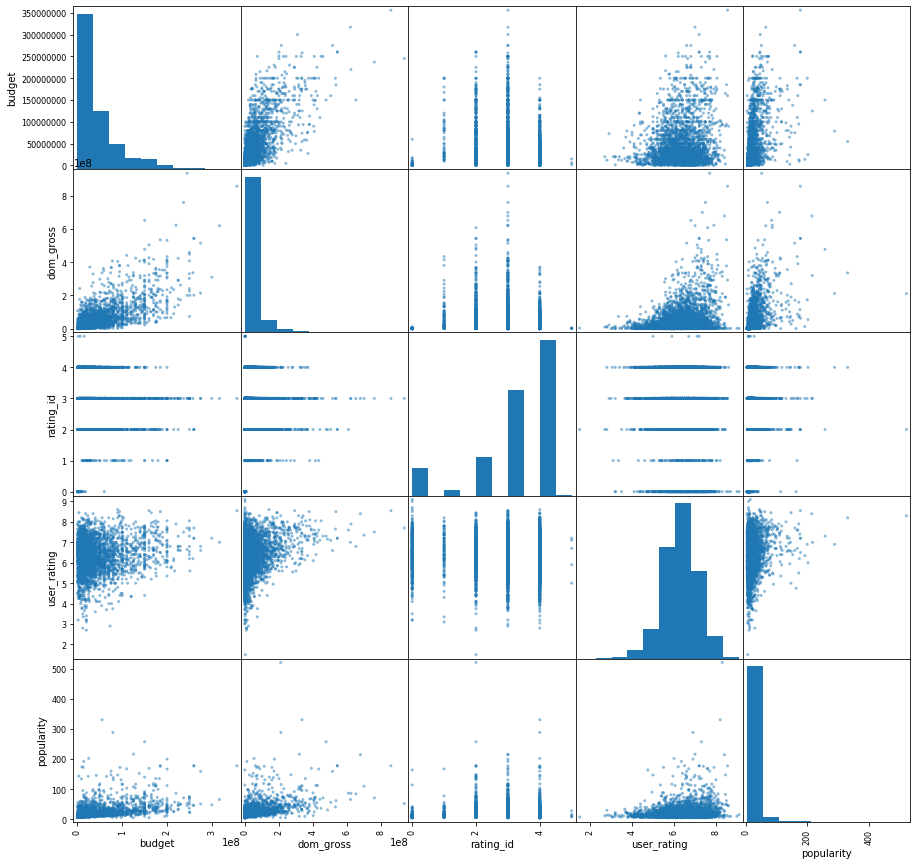

In [138]:
pd.plotting.scatter_matrix(master_movies[['budget', 'dom_gross', 'rating_id', 'user_rating', 'popularity']], figsize=(15, 15));

In [139]:
# investigate correlations with user_rating
master_movies.corr()['user_rating'].sort_values()
# user rating seems to have no correlation with how well the movie does

rating_id      -0.065558
is_franchise   -0.001569
budget          0.158815
popularity      0.171095
dom_gross       0.232589
world_gross     0.233281
total_votes     0.276648
dom_net         0.314401
world_net       0.324215
user_rating     1.000000
Name: user_rating, dtype: float64

In [140]:
movies_withbudget.corr()['budget'].sort_values()
# budget has some correlation with gross/net. Which makes sense.
# budget has nearly no correlation with NET. That seems weird.

rating_id      -0.229205
dom_net         0.135884
user_rating     0.158815
is_franchise    0.232681
total_votes     0.386143
popularity      0.429586
world_net       0.627469
dom_gross       0.695697
world_gross     0.751801
budget          1.000000
Name: budget, dtype: float64

In [141]:
master_movies.corr()['popularity'].sort_values()
# a movie's popularity has only minor correlation with gross/net

rating_id       0.008207
user_rating     0.171095
total_votes     0.322318
is_franchise    0.338176
dom_net         0.360512
budget          0.429586
world_net       0.549223
dom_gross       0.555519
world_gross     0.589952
popularity      1.000000
Name: popularity, dtype: float64

In [142]:
master_movies.corr()['rating_id'].sort_values()

budget         -0.229205
world_net      -0.161854
dom_net        -0.075773
user_rating    -0.065558
world_gross    -0.055211
dom_gross      -0.049088
is_franchise    0.006440
popularity      0.008207
total_votes     0.063282
rating_id       1.000000
Name: rating_id, dtype: float64

In [143]:
master_movies.sort_values('dom_gross', ascending=False).head(30)
# top 30 grossing movies, domestic

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,
tt2488496,52.273,Star Wars The Force Awakens,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,PG-13,245000000.0,936662225.0,2.068454e+09,3,NaN,7.70,799850.0,691662225.0,1.823454e+09,False
tt4154796,177.346,Avengers Endgame,2019-04-24,"[12, 878, 28]",Walt Disney Studios Motion Pictures,PG-13,356000000.0,858373000.0,2.797801e+09,3,Marvel Cinematic Universe,8.55,456667.0,502373000.0,2.441801e+09,True
tt0499549,70.878,Avatar,2009-12-10,"[28, 12, 14, 878]",Twentieth Century Fox,PG-13,237000000.0,760507625.0,2.790439e+09,3,Avatar,7.50,22270.0,523507625.0,2.553439e+09,True
tt1825683,109.772,Black Panther,2018-02-13,"[28, 12, 14, 878]",Walt Disney Studios Motion Pictures,PG-13,NaN,700426566.0,1.347462e+09,3,Marvel Cinematic Universe,7.35,532388.0,NaN,NaN,True
tt4154756,214.301,Avengers Infinity War,2018-04-25,"[12, 28, 878]",Walt Disney Studios Motion Pictures,PG-13,NaN,678815482.0,2.048360e+09,3,Marvel Cinematic Universe,8.40,690980.0,NaN,NaN,True
tt0369610,84.240,Jurassic World,2015-06-06,"[28, 12, 878, 53]",Universal Pictures,PG-13,150000000.0,652270625.0,1.670401e+09,3,Jurassic Park,6.80,555492.0,502270625.0,1.520401e+09,True
tt0848228,86.260,The Avengers,2012-04-25,"[878, 28, 12]",Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,Marvel Cinematic Universe,7.90,1207036.0,403357910.0,1.298816e+09,True
tt2527336,65.624,Star Wars The Last Jedi,2017-12-13,"[28, 12, 878]",Walt Disney Studios Motion Pictures,PG-13,317000000.0,620181382.0,1.332697e+09,3,NaN,7.00,474088.0,303181382.0,1.015697e+09,False
tt3606756,86.453,Incredibles 2,2018-06-14,"[28, 12, 16, 10751]",Walt Disney Studios Motion Pictures,PG,NaN,608581744.0,1.242805e+09,2,The Incredibles,7.60,212769.0,NaN,NaN,True


In [144]:
master_movies.sort_values('dom_net', ascending=False).head(30)

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,
tt2488496,52.273,Star Wars The Force Awakens,2015-12-15,"[28, 12, 878, 14]",Walt Disney Studios Motion Pictures,PG-13,245000000.0,936662225.0,2.068454e+09,3,NaN,7.70,799850.0,691662225.0,1.823454e+09,False
tt0499549,70.878,Avatar,2009-12-10,"[28, 12, 14, 878]",Twentieth Century Fox,PG-13,237000000.0,760507625.0,2.790439e+09,3,Avatar,7.50,22270.0,523507625.0,2.553439e+09,True
tt4154796,177.346,Avengers Endgame,2019-04-24,"[12, 878, 28]",Walt Disney Studios Motion Pictures,PG-13,356000000.0,858373000.0,2.797801e+09,3,Marvel Cinematic Universe,8.55,456667.0,502373000.0,2.441801e+09,True
tt0369610,84.240,Jurassic World,2015-06-06,"[28, 12, 878, 53]",Universal Pictures,PG-13,150000000.0,652270625.0,1.670401e+09,3,Jurassic Park,6.80,555492.0,502270625.0,1.520401e+09,True
tt0848228,86.260,The Avengers,2012-04-25,"[878, 28, 12]",Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,Marvel Cinematic Universe,7.90,1207036.0,403357910.0,1.298816e+09,True
tt0468569,61.787,The Dark Knight,2008-07-16,"[18, 28, 80, 53]",Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3,Batman,8.50,23590.0,350234033.0,8.204568e+08,True
tt2771200,56.161,Beauty and the Beast,2017-03-16,"[10751, 14, 10749]",Walt Disney Studios Motion Pictures,PG,160000000.0,504481165.0,1.264064e+09,2,Beauty and the Beast,7.10,251238.0,344481165.0,1.104064e+09,True
tt0335345,38.615,The Passion of the Christ,2004-02-25,[18],Newmarket Films,R,27500000.0,370782930.0,6.171982e+08,4,NaN,7.30,2652.0,343282930.0,5.896982e+08,False
tt3748528,40.837,Rogue One A Star Wars Story,2016-12-14,"[28, 12, 878]",Walt Disney Studios Motion Pictures,PG-13,200000000.0,532177324.0,1.056058e+09,3,Star Wars,7.65,490033.0,332177324.0,8.560577e+08,True


In [145]:
master_movies.dtypes

popularity             float64
title                   object
release_date    datetime64[ns]
genres                  object
studio                  object
mpaa_rating             object
budget                 float64
dom_gross              float64
world_gross            float64
rating_id                int64
franchise               object
user_rating            float64
total_votes            float64
dom_net                float64
world_net              float64
is_franchise              bool
dtype: object

In [148]:
master_movies.groupby('is_franchise').mean()

,popularity,budget,dom_gross,world_gross,rating_id,user_rating,total_votes,dom_net,world_net
is_franchise,,,,,,,,,
False,16.476564,4.060444e+07,2.614530e+07,5.715362e+07,3.065255,6.316314,32848.789688,6.171632e+06,6.036475e+07
True,36.978805,6.838772e+07,1.096002e+08,2.703039e+08,3.087819,6.312465,99412.186969,4.876490e+07,2.190187e+08


### Studying Studio Stats

In [ ]:
master_movies.groupby('studio').mean().sort_values('dom_gross', ascending=False)
# sorting by average dom_gross, we see our top performing studios which produce the biggest blockbusters on average

# 344 studios made our 6749 movies

In [ ]:
master_movies.groupby('studio').sum().sort_values('world_gross', ascending=False).head(10)
# sorting on world gross as a sum, we see which studios bring in the most overall gross

In [ ]:
movies_withbudget.groupby('studio').mean().sort_values('dom_net', ascending=False).head(10)
# sorting on domestic net on average, we get some interesting results. Our big flashy studios are still there,
# but there are some smaller studios that have a very respectable domestic net income per film
# Pantelion films spent $12mil on a single film that ultimately netted $38mil domestic, which is only about $7mil less
# than the average Disney film nets domestically. Now, the WORLDWIDE net differs greatly ($79mil vs Disney's $260mil),
# but overall we can understand that we can get respectable results on a smaller budget if we do it right

In [ ]:
master_movies['studio'].value_counts()

## Studying some cast and crew info

In [ ]:
cast_crew.columns

In [ ]:
cast_crew['category'].unique()
#What kinds of categories are tracked?

### Director

In [ ]:
# make a new series based on the director of the movie
director = cast_crew[cast_crew['category'] == 'director']

In [ ]:
# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 1577 different directors for our movies

In [ ]:
# Checking how many movies each director has directed.
director.groupby(['primary_name']).count().value_counts('title')
#1015 of our directors have directed only one movie

In [ ]:
# select directors that have directed at least 2 movies, so that we know they are proven
#director = director[director.duplicated(subset='primary_name', keep=False)]

# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 562 repeat directors

In [ ]:
# Looking at the mean domestic gross of our top 30 directors
directortop30 = director.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
directortop30

In [ ]:
# Bar graph of the domestic gross of our top 30 directors
graphit = directortop30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Mean Dom Gross by Director')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

### Actor

In [ ]:
# checking out the actors in our top 30 grossing movies
actor = cast_crew[cast_crew['category'] == 'actor']
actor30 = actor.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actor30

In [ ]:
# Your code here
graphit = actor30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actors in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actor')
graphit.plot();

In [ ]:
# Looking at the mean domestic gross of the actors
actormean = actor.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
actormean

### Actress

In [ ]:
# checking out the actresses in our top 30 grossing movies
actress = cast_crew[cast_crew['category'] == 'actress']
actress30 = actress.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actress30

In [ ]:
# Your code here
graphit = actress30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actresses in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actress')
graphit.plot();

### Writer

In [ ]:
# make a new series based on the writer of the movie
writer = cast_crew[cast_crew['category'] == 'writer']

In [ ]:
# checking out our mean values for this group
writer.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 3983 different writers for our list of 6729 movies

In [ ]:
# Checking how many movies each writer has written.
writer.groupby(['primary_name']).count().value_counts('title')
# most of our writers have only written one movie!

In [ ]:
# Looking at the mean domestic gross of our top 30 writers
writertop30 = writer.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
writertop30

In [ ]:
# Bar graph of the domestic gross of our top 30 directors
graphit = writertop30.sort_values().plot(kind='barh', figsize=(20,10))
#deaths = df.groupby(['State'])['Deaths'].sum().sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Dom Gross by Writer')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

In [ ]:
master_movies.sort_values('dom_gross', ascending=False).head(50)

# TO DO

Break out genres, and study numbers vs genre

Study franchises

Look closer into the net income information to give specific examples of smaller movies that were profitable

Visualizations/EDA to gather:
* gross/net by team of writer-director
* gross/net of franchise vs non-franchise
* gross/net by genre
* gross/net by genre+franchise status
* gross/net against studio
* check out genres of franchises
* gross/net by MPAA rating
* scatter with directors vs gross where size is how many movies they have directed



Do all of the functions have docstrings?
Did I follow PEP8?